In [1]:
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU

In [2]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")


# perform exploratory data analysis
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_fake['isfake'] = 0


# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)


# combine title and text together
df['original'] = df['title'] + ' ' + df['text']

In [3]:
# perform data cleaning
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result


# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [5]:
# Obtain the total words present in the dataset
list_of_words = []

for i in df.clean:
    for j in i:
        list_of_words.append(j)
        
        
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))

# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [6]:
# performing tokenization and padding
'''
tokenizer allows us to vectorize text corpus by turning each text into a sequence of integers.
for example:
sentence: " budget fight looms republicans flip fiscal script "
tokens: [214, 3512, 15, 485, 652, 1856, 2654]
'''


# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [7]:
from nltk import word_tokenize

# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [8]:
# building the deep learning for fake news detection using LSTM Bidirectional

# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [9]:
y_train = np.asarray(y_train)

# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 133s 249ms/step - loss: 0.0422 - acc: 0.9852 - val_loss: 0.0099 - val_acc: 0.9983
Epoch 2/2
506/506 [==============================] - 123s 243ms/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0041 - val_acc: 0.9992


In [10]:
# assess trained model performance
# make prediction
pred = model.predict(padded_test)

281/281 [==============================] - 10s 28ms/step


In [11]:
prediction = []

# if the predicted value is >0.5 it is real else it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

        
# getting the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9946547884187082


In [17]:
# building the deep learning for fake news detection using LSTM
model = Sequential()

model.add(Embedding(total_words, output_dim = 128))
model.add(LSTM(128))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         13914112  
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,062,337
Trainable params: 14,062,337
Non-trainable params: 0
_________________________________________________________________


In [18]:
y_train = np.asarray(y_train)

model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 107s 205ms/step - loss: 0.0443 - acc: 0.9791 - val_loss: 0.0090 - val_acc: 0.9983
Epoch 2/2
506/506 [==============================] - 91s 181ms/step - loss: 0.1602 - acc: 0.9069 - val_loss: 0.2255 - val_acc: 0.9844


In [19]:
pred = model.predict(padded_test)

281/281 [==============================] - 4s 14ms/step


In [20]:
prediction = []

for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
        
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9863028953229399


In [21]:
# building the deep learning for fake news detection using GRU
model = Sequential()

model.add(Embedding(total_words, output_dim = 128))
model.add(GRU(128))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         13914112  
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,029,825
Trainable params: 14,029,825
Non-trainable params: 0
_________________________________________________________________


In [22]:
y_train = np.asarray(y_train)

model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 120s 184ms/step - loss: 0.0665 - acc: 0.9659 - val_loss: 0.0061 - val_acc: 0.9989
Epoch 2/2
506/506 [==============================] - 100s 198ms/step - loss: 0.0059 - acc: 0.9992 - val_loss: 0.0058 - val_acc: 0.9986


In [23]:
pred = model.predict(padded_test)

281/281 [==============================] - 4s 11ms/step


In [24]:
prediction = []

for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
        
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9969933184855234


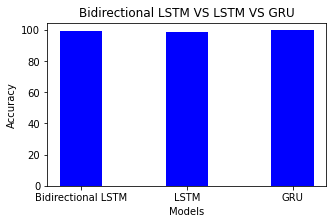

In [10]:
import numpy as np
import matplotlib.pyplot as plt

data = {'Bidirectional LSTM':99.46547884187082, 'LSTM':98.63028953229399, 'GRU':99.69933184855234}
Models = list(data.keys())
Accuracy = list(data.values())
  
fig = plt.figure(figsize = (5, 3))
 
# creating the bar plot
plt.bar(Models, Accuracy, color ='blue',width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Bidirectional LSTM VS LSTM VS GRU")
plt.show()